<a href="https://colab.research.google.com/github/Gulwalishah/CLT/blob/main/Spline_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch 1/10 | Train Loss: 2.2885, Train Acc: 24.75% | Test Loss: 2.2476, Test Acc: 56.24%
Epoch 2/10 | Train Loss: 2.0003, Train Acc: 59.24% | Test Loss: 1.4576, Test Acc: 71.65%
Epoch 3/10 | Train Loss: 1.0850, Train Acc: 76.74% | Test Loss: 0.7022, Test Acc: 86.78%
Epoch 4/10 | Train Loss: 0.5941, Train Acc: 88.44% | Test Loss: 0.4015, Test Acc: 93.39%
Epoch 5/10 | Train Loss: 0.3728, Train Acc: 92.51% | Test Loss: 0.2646, Test Acc: 94.71%
Epoch 6/10 | Train Loss: 0.2598, Train Acc: 94.08% | Test Loss: 0.1905, Test Acc: 95.67%
Epoch 7/10 | Train Loss: 0.1981, Train Acc: 95.04% | Test Loss: 0.1596, Test Acc: 95.95%
Epoch 8/10 | Train Loss: 0.1612, Train Acc: 95.75% | Test Loss: 0.1359, Test Acc: 96.44%
Epoch 9/10 | Train Loss: 0.1389, Train Acc: 96.17% | Test Loss: 0.1224, Test Acc: 96.70%
Epoch 10/10 | Train Loss: 0.1176, Train Acc: 96.68% | Test Loss: 0.1128, Test Acc: 96.85%


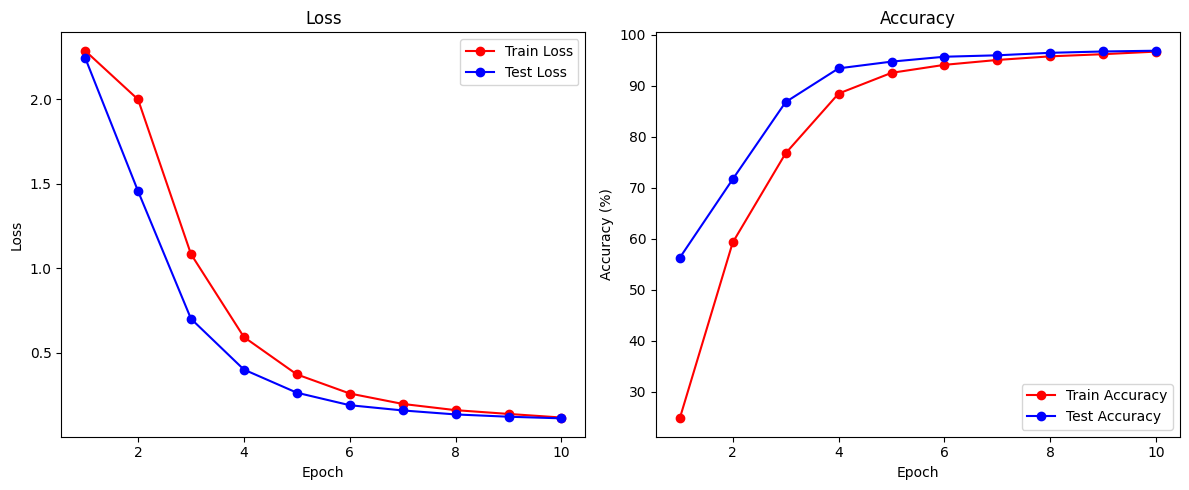

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#############################
# 1) Define Spline & Penalty
#############################
class BSplineActivation(nn.Module):
    """
    1D B-spline (triangular basis) activation on a uniform grid.
    """
    def __init__(self, num_knots=250, knot_spacing=0.05):
        super().__init__()
        self.num_knots = num_knots
        self.knot_spacing = knot_spacing
        # Zero initialization for smoother start
        self.coeffs = nn.Parameter(torch.zeros(num_knots))
        # Knot positions
        knots = torch.arange(num_knots) * knot_spacing
        self.register_buffer('knot_positions', knots)

    def forward(self, x):
        # Flatten input for basis computation
        orig_shape = x.shape
        x_flat = x.view(-1, 1)
        dist = torch.abs(x_flat - self.knot_positions.view(1, -1))
        phi = F.relu(1.0 - dist / self.knot_spacing)  # triangular basis
        out_flat = phi @ self.coeffs
        return out_flat.view(orig_shape)


def tv2_penalty(coeffs):
    """
    2nd-order Total Variation penalty: encourages smooth spline coefficients.
    """
    second_diff = coeffs[2:] - 2 * coeffs[1:-1] + coeffs[:-2]
    return torch.sum(torch.abs(second_diff))


##############################
# 2) Spline-Activated Network
##############################
class SplineMNISTNet(nn.Module):
    """
    3-layer MLP + final output, using Spline activation in each layer.
    """
    def __init__(self, input_dim=784, hidden_dim=256,
                 num_knots=250, knot_spacing=0.05,
                 dropout_p=0.15):
        super().__init__()
        # Layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(dropout_p)
        self.fc4 = nn.Linear(hidden_dim, 10)

        # Spline activation
        self.spline_activation = BSplineActivation(num_knots, knot_spacing)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.spline_activation(x)
        x = self.dropout(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.spline_activation(x)
        x = self.dropout(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.spline_activation(x)
        x = self.dropout(x)

        # Output
        x = self.fc4(x)
        return x


#################################
# 3) Training & Evaluation Loops
#################################
from torch.amp import autocast, GradScaler  # New AMP imports

def train_epoch(
    model, dataloader, optimizer, device,
    epoch, warmup_epochs=5,
    base_tv=1e-5, max_tv=1e-4, use_amp=True
):
    model.train()
    # Dynamically choose device_type for autocast
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'
    scaler = GradScaler(enabled=use_amp)

    total_loss, correct, total = 0.0, 0, 0

    # Turn off TV penalty for warm-up epochs
    if epoch <= warmup_epochs:
        dynamic_tv = 0.0
    else:
        # ramp up TV from base_tv by 1e-6 each epoch, clamped at max_tv
        dynamic_tv = min(max_tv, base_tv + (epoch * 1e-6))

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()

        # Mixed Precision Context
        with autocast(device_type=device_type, enabled=use_amp):
            logits = model(images)
            ce_loss = F.cross_entropy(logits, labels)
            penalty = tv2_penalty(model.spline_activation.coeffs)
            loss = ce_loss + dynamic_tv * penalty

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            total_loss += ce_loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def evaluate(model, dataloader, device, use_amp=True):
    model.eval()
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad(), autocast(device_type=device_type, enabled=use_amp):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)

            logits = model(images)
            ce_loss = F.cross_entropy(logits, labels)

            total_loss += ce_loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return (total_loss / total), (100.0 * correct / total)


########################################
# 4) Main Training Script (No Confusion)
########################################
from torch.optim.lr_scheduler import OneCycleLR

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # Hyperparameters
    EPOCHS = 10
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    HIDDEN_DIM = 512  # was 256
    LAMBDA_TV = 1e-5  # base TV penalty
    USE_AMP = True    # Enable or disable mixed precision
    WARMUP_EPOCHS = 5

    # Data Transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Build Model
    model = SplineMNISTNet(
        input_dim=784,
        hidden_dim=HIDDEN_DIM,
        num_knots=250,  # can adjust
        knot_spacing=0.05,
        dropout_p=0.15
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    # Learning Rate Scheduler (OneCycleLR)
    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS
    )

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    # Training Loop
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, device,
            epoch=epoch, warmup_epochs=WARMUP_EPOCHS,
            base_tv=LAMBDA_TV, max_tv=1e-4, use_amp=USE_AMP
        )
        # After each epoch, evaluate
        test_loss, test_acc = evaluate(model, test_loader, device, use_amp=USE_AMP)

        # OneCycleLR step each epoch
        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch}/{EPOCHS} "
              f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Plot Results
    epochs_range = range(1, EPOCHS + 1)
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'r-o', label='Train Loss')
    plt.plot(epochs_range, test_losses, 'b-o', label='Test Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'r-o', label='Train Accuracy')
    plt.plot(epochs_range, test_accs, 'b-o', label='Test Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()


Using device: cuda
Epoch 1/110 | Train Loss: 2.0810, Train Acc: 51.04% | Test Loss: 1.5518, Test Acc: 75.74%
Epoch 2/110 | Train Loss: 1.0586, Train Acc: 81.44% | Test Loss: 0.6059, Test Acc: 89.44%
Epoch 3/110 | Train Loss: 0.4939, Train Acc: 89.64% | Test Loss: 0.3264, Test Acc: 92.41%
Epoch 4/110 | Train Loss: 0.3188, Train Acc: 91.85% | Test Loss: 0.2347, Test Acc: 93.66%
Epoch 5/110 | Train Loss: 0.2429, Train Acc: 93.34% | Test Loss: 0.1900, Test Acc: 94.57%
Epoch 6/110 | Train Loss: 0.1996, Train Acc: 94.30% | Test Loss: 0.1664, Test Acc: 95.21%
Epoch 7/110 | Train Loss: 0.1658, Train Acc: 95.30% | Test Loss: 0.1460, Test Acc: 95.66%
Epoch 8/110 | Train Loss: 0.1463, Train Acc: 95.67% | Test Loss: 0.1298, Test Acc: 96.04%
Epoch 9/110 | Train Loss: 0.1277, Train Acc: 96.27% | Test Loss: 0.1200, Test Acc: 96.38%
Epoch 10/110 | Train Loss: 0.1117, Train Acc: 96.66% | Test Loss: 0.1138, Test Acc: 96.65%
Epoch 11/110 | Train Loss: 0.1007, Train Acc: 96.99% | Test Loss: 0.1101, Test A

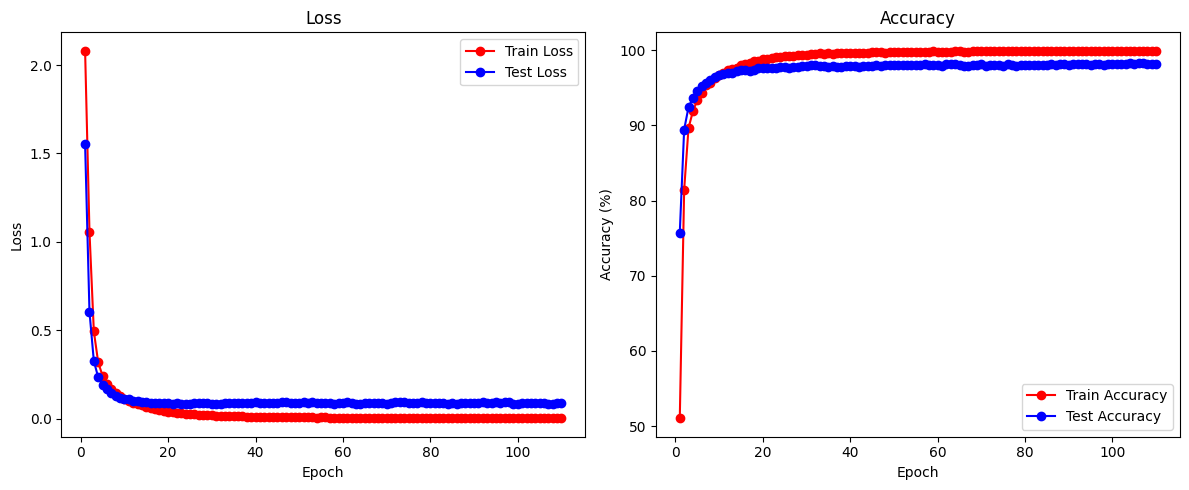

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#############################
# 1) Define Localized Spline & Penalty
#############################
class BSplineActivation(nn.Module):
    """
    1D B-spline (triangular basis) activation on a uniform grid, implemented
    via a localized approach. Each x only influences two adjacent knots,
    greatly reducing the computation from O(B*D*num_knots) to O(B*D).
    """
    def __init__(self, num_knots=250, knot_spacing=0.05):
        super().__init__()
        self.num_knots = num_knots
        self.knot_spacing = knot_spacing
        # Zero initialization for smoother start
        self.coeffs = nn.Parameter(torch.zeros(num_knots))
        # Knot positions: knots[i] = i * knot_spacing
        self.register_buffer('knot_positions', torch.arange(num_knots) * knot_spacing)

    def forward(self, x):
        orig_shape = x.shape
        # Flatten input to 1D
        x_flat = x.view(-1)

        # 1) Clamp x to the range [0, (num_knots-1)*knot_spacing]
        #    If you have negative inputs, consider shifting knot positions
        #    or using a bigger range. For demonstration, we clamp below.
        max_knot = self.knot_positions[-1]
        x_clamped = torch.clamp(x_flat, 0.0, max_knot)

        # 2) Find the index of the 'left' knot for each x
        #    idx in [0, num_knots-2]
        idx_float = x_clamped.div(self.knot_spacing)  # approximate index
        idx_left = torch.floor(idx_float).long()
        idx_left = torch.clamp(idx_left, 0, self.num_knots - 2)

        # 3) Compute interpolation factor alpha
        #    alpha = (x_clamped - knots[idx_left]) / knot_spacing
        left_knot_pos = self.knot_positions[idx_left]  # gather left knot pos
        alpha = (x_clamped - left_knot_pos) / self.knot_spacing  # in [0,1]

        # 4) Linearly blend the left and right coefficients
        coeff_left = self.coeffs[idx_left]
        coeff_right = self.coeffs[idx_left + 1]
        out_flat = (1 - alpha) * coeff_left + alpha * coeff_right

        # Reshape back to original
        return out_flat.view(orig_shape)


def tv2_penalty(coeffs):
    """
    2nd-order Total Variation penalty: encourages smooth spline coefficients.
    """
    second_diff = coeffs[2:] - 2 * coeffs[1:-1] + coeffs[:-2]
    return torch.sum(torch.abs(second_diff))


##############################
# 2) Spline-Activated Network
##############################
class SplineMNISTNet(nn.Module):
    """
    3-layer MLP + final output, using Spline activation in each layer.
    """
    def __init__(self, input_dim=784, hidden_dim=256,
                 num_knots=250, knot_spacing=0.05,
                 dropout_p=0.15):
        super().__init__()
        # Layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)

        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)

        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        self.dropout = nn.Dropout(dropout_p)
        self.fc4 = nn.Linear(hidden_dim, 10)

        # Spline activation
        self.spline_activation = BSplineActivation(num_knots, knot_spacing)

    def forward(self, x):
        # Layer 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.spline_activation(x)
        x = self.dropout(x)

        # Layer 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.spline_activation(x)
        x = self.dropout(x)

        # Layer 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.spline_activation(x)
        x = self.dropout(x)

        # Output
        x = self.fc4(x)
        return x


#################################
# 3) Training & Evaluation Loops
#################################
from torch.amp import autocast, GradScaler

def train_epoch(
    model, dataloader, optimizer, device,
    epoch, warmup_epochs=5,
    base_tv=1e-5, max_tv=1e-4, use_amp=True
):
    model.train()
    # Dynamically choose device_type for autocast
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'
    scaler = GradScaler(enabled=use_amp)

    total_loss, correct, total = 0.0, 0, 0

    # Turn off TV penalty for warm-up epochs
    if epoch <= warmup_epochs:
        dynamic_tv = 0.0
    else:
        # ramp up TV from base_tv by 1e-6 each epoch, clamped at max_tv
        dynamic_tv = min(max_tv, base_tv + (epoch * 1e-6))

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)

        optimizer.zero_grad()

        with autocast(device_type=device_type, enabled=use_amp):
            logits = model(images)
            ce_loss = F.cross_entropy(logits, labels)
            penalty = tv2_penalty(model.spline_activation.coeffs)
            loss = ce_loss + dynamic_tv * penalty

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            total_loss += ce_loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


def evaluate(model, dataloader, device, use_amp=True):
    model.eval()
    device_type = 'cuda' if device.type == 'cuda' else 'cpu'
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad(), autocast(device_type=device_type, enabled=use_amp):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            images = images.view(images.size(0), -1)

            logits = model(images)
            ce_loss = F.cross_entropy(logits, labels)

            total_loss += ce_loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return (total_loss / total), (100.0 * correct / total)


########################################
# 4) Main Training Script
########################################
from torch.optim.lr_scheduler import OneCycleLR

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using device:", device)

    # Hyperparameters
    EPOCHS = 110
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-3
    HIDDEN_DIM = 512
    LAMBDA_TV = 1e-5  # base TV penalty
    USE_AMP = True
    WARMUP_EPOCHS = 5

    # Data Transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Build Model
    model = SplineMNISTNet(
        input_dim=784,
        hidden_dim=HIDDEN_DIM,
        num_knots=250,
        knot_spacing=0.05,
        dropout_p=0.15
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    # Learning Rate Scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=LEARNING_RATE,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS
    )

    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    # Training Loop
    for epoch in range(1, EPOCHS + 1):
        train_loss, train_acc = train_epoch(
            model, train_loader, optimizer, device,
            epoch=epoch, warmup_epochs=WARMUP_EPOCHS,
            base_tv=LAMBDA_TV, max_tv=1e-4, use_amp=USE_AMP
        )
        test_loss, test_acc = evaluate(model, test_loader, device, use_amp=USE_AMP)

        scheduler.step()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Epoch {epoch}/{EPOCHS} "
              f"| Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
              f"| Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

    # Plot Results
    epochs_range = range(1, EPOCHS + 1)
    plt.figure(figsize=(12, 5))

    # Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, 'r-o', label='Train Loss')
    plt.plot(epochs_range, test_losses, 'b-o', label='Test Loss')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, 'r-o', label='Train Accuracy')
    plt.plot(epochs_range, test_accs, 'b-o', label='Test Accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
